## BO with TuRBO-1 and TS/qEI

In this tutorial, we show how to implement Trust Region Bayesian Optimization (TuRBO) [1] in a closed loop in BoTorch.

This implementation uses one trust region (TuRBO-1) and supports either parallel expected improvement (qEI) or Thompson sampling (TS). We optimize the $20D$ Ackley function on the domain $[-5, 10]^{20}$ and show that TuRBO-1 outperforms qEI as well as Sobol.

Since botorch assumes a maximization problem, we will attempt to maximize $-f(x)$ to achieve $\max_x -f(x)=0$.

[1]: [Eriksson, David, et al. Scalable global optimization via local Bayesian optimization. Advances in Neural Information Processing Systems. 2019](https://proceedings.neurips.cc/paper/2019/file/6c990b7aca7bc7058f5e98ea909e924b-Paper.pdf)


In [ ]:
# Install dependencies if we are running in colab
import sys

if "google.colab" in sys.modules:
    %pip install botorch

In [ ]:
import math
import os
import warnings
from dataclasses import dataclass
from typing import Optional

import gpytorch
import torch
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.quasirandom import SobolEngine

from botorch.acquisition import qExpectedImprovement, qLogExpectedImprovement
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.test_functions import Ackley
from botorch.utils.transforms import unnormalize


warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

## Optimize the 20-dimensional Ackley function

The goal is to minimize the popular Ackley function:

$f(x_1,\ldots,x_d) = -20\exp\left(-0.2 \sqrt{\frac{1}{d} \sum_{j=1}^d x_j^2} \right) -\exp \left( \frac{1}{d} \sum_{j=1}^d \cos(2 \pi x_j) \right) + 20 + e$

over the domain  $[-5, 10]^{20}$.  The global optimal value of $0$ is attained at $x_1 = \ldots = x_d = 0$.

As mentioned above, since botorch assumes a maximization problem, we instead maximize $-f(x)$.

In [ ]:
fun = Ackley(dim=20, negate=True).to(dtype=dtype, device=device)
fun.bounds[0, :].fill_(-5)
fun.bounds[1, :].fill_(10)
dim = fun.dim
lb, ub = fun.bounds

batch_size = 4
n_init = 2 * dim
max_cholesky_size = float("inf")  # Always use Cholesky


def eval_objective(x: torch.Tensor) -> torch.Tensor:
    """This is a helper function we use to unnormalize and evalaute a point."""
    return fun(unnormalize(x, fun.bounds))

## Maintain the TuRBO state
TuRBO needs to maintain a state, which includes the length of the trust region, success and failure counters, success and failure tolerance, etc. 

In this tutorial we store the state in a dataclass and update the state of TuRBO after each batch evaluation. 

**Note**: These settings assume that the domain has been scaled to $[0, 1]^d$ and that the same batch size is used for each iteration.

In [ ]:
@dataclass
class TurboState:
    """Turbo state used to track the recent history of the trust region."""
    dim: int
    batch_size: int
    length: float = 0.8
    length_min: float = 0.5**7
    length_max: float = 1.6
    failure_counter: int = 0
    failure_tolerance: int = float("nan")  # Note: Post-initialized
    success_counter: int = 0
    success_tolerance: int = 10  # Note: The original paper uses 3
    best_value: float = -float("inf")
    restart_triggered: bool = False

    def __post_init__(self):
        """Post-initialize the state of the trust region."""
        self.failure_tolerance = math.ceil(
            max([4.0 / self.batch_size, float(self.dim) / self.batch_size])
        )


def update_state(state: TurboState, Y_next: torch.Tensor) -> TurboState:
    """Update the state of the trust region based on the new function values."""
    if max(Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value):
        state.success_counter += 1
        state.failure_counter = 0
    else:
        state.success_counter = 0
        state.failure_counter += 1

    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0

    state.best_value = max(state.best_value, max(Y_next).item())
    if state.length < state.length_min:
        state.restart_triggered = True
    return state

## Take a look at the state

In [ ]:
state = TurboState(dim=dim, batch_size=batch_size)
print(state)

TurboState(dim=20, batch_size=4, length=0.8, length_min=0.0078125, length_max=1.6, failure_counter=0, failure_tolerance=5, success_counter=0, success_tolerance=10, best_value=-inf, restart_triggered=False)


## Generate initial points
This generates an initial set of Sobol points that we use to start of the BO loop.

In [ ]:
def get_initial_points(dim: int, n_pts: int, seed: int = 0) -> torch.Tensor:
    """Generate initial points using Sobol sequence."""
    sobol = SobolEngine(dimension=dim, scramble=True, seed=seed)
    return sobol.draw(n=n_pts).to(dtype=dtype, device=device)

## Generate new batch
Given the current `state` and a probabilistic (GP) `model` built from observations `X` and `Y`, we generate a new batch of points.  

This method works on the domain $[0, 1]^d$, so make sure to not pass in observations from the true domain.  `unnormalize` is called before the true function is evaluated which will first map the points back to the original domain.

We support either TS and qEI which can be specified via the `acqf` argument.

In [ ]:
def generate_batch(
    state: TurboState,
    model: SingleTaskGP,  # GP model
    X: torch.Tensor,  # Evaluated points on the domain [0, 1]^d
    Y: torch.Tensor,  # Function values
    batch_size: int,
    n_candidates: Optional[int] = None,  # Number of candidates for Thompson sampling
    num_restarts: int = 10,
    raw_samples: int = 512,
    acqf: str = "ts",  # "ei" or "ts"
) -> torch.Tensor:
    """Generate a new batch of points."""
    assert acqf in ("ts", "ei")
    assert X.min() >= 0.0
    assert X.max() <= 1.0
    assert torch.all(torch.isfinite(Y))
    if n_candidates is None:
        n_candidates = min(5000, max(2000, 200 * X.shape[-1]))

    # Scale the TR to be proportional to the lengthscales
    x_center = X[Y.argmax(), :].clone()
    weights = model.covar_module.base_kernel.lengthscale.squeeze().detach()
    weights = weights / weights.mean()
    weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
    tr_lb = torch.clamp(x_center - weights * state.length / 2.0, 0.0, 1.0)
    tr_ub = torch.clamp(x_center + weights * state.length / 2.0, 0.0, 1.0)

    if acqf == "ts":
        dim = X.shape[-1]
        sobol = SobolEngine(dim, scramble=True)
        pert = sobol.draw(n_candidates).to(dtype=dtype, device=device)
        pert = tr_lb + (tr_ub - tr_lb) * pert

        # Create a perturbation mask
        prob_perturb = min(20.0 / dim, 1.0)
        mask = torch.rand(n_candidates, dim, dtype=dtype, device=device) <= prob_perturb
        ind = torch.where(mask.sum(dim=1) == 0)[0]
        mask[ind, torch.randint(0, dim - 1, size=(len(ind),), device=device)] = 1

        # Create candidate points from the perturbations and the mask
        X_cand = x_center.expand(n_candidates, dim).clone()
        X_cand[mask] = pert[mask]

        # Sample on the candidate points
        thompson_sampling = MaxPosteriorSampling(model=model, replacement=False)
        with torch.no_grad():  # We don't need gradients when using TS
            X_next = thompson_sampling(X_cand, num_samples=batch_size)

    elif acqf == "ei":
        ei = qExpectedImprovement(model, Y.max())
        X_next, acq_value = optimize_acqf(
            ei,
            bounds=torch.stack([tr_lb, tr_ub]),
            q=batch_size,
            num_restarts=num_restarts,
            raw_samples=raw_samples,
        )

    return X_next

## Optimization loop
This simple loop runs one instance of TuRBO-1 with Thompson sampling until convergence.

TuRBO-1 is a local optimizer that can be used for a fixed evaluation budget in a multi-start fashion.  Once TuRBO converges, `state["restart_triggered"]` will be set to true and the run should be aborted.  If you want to run more evaluations with TuRBO, you simply generate a new set of initial points and then keep generating batches until convergence or when the evaluation budget has been exceeded.  It's important to note that evaluations from previous instances are discarded when TuRBO restarts.

NOTE: We use a `SingleTaskGP` with a noise constraint to keep the noise from getting too large as the problem is noise-free. 

In [ ]:
X_turbo = get_initial_points(dim, n_init)
Y_turbo = torch.tensor(
    [eval_objective(x) for x in X_turbo], dtype=dtype, device=device
).unsqueeze(-1)

state = TurboState(dim, batch_size=batch_size, best_value=max(Y_turbo).item())

NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4
N_CANDIDATES = min(5000, max(2000, 200 * dim)) if not SMOKE_TEST else 4

torch.manual_seed(0)

while not state.restart_triggered:  # Run until TuRBO converges
    # Fit a GP model
    train_Y = (Y_turbo - Y_turbo.mean()) / Y_turbo.std()
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
        MaternKernel(nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0))
    )
    model = SingleTaskGP(X_turbo, train_Y, covar_module=covar_module, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    # Do the fitting and acquisition function optimization inside the Cholesky context
    with gpytorch.settings.max_cholesky_size(max_cholesky_size):
        # Fit the model
        fit_gpytorch_mll(mll)

        # Create a batch
        X_next = generate_batch(
            state=state,
            model=model,
            X=X_turbo,
            Y=train_Y,
            batch_size=batch_size,
            n_candidates=N_CANDIDATES,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
            acqf="ts",
        )

    Y_next = torch.tensor(
        [eval_objective(x) for x in X_next], dtype=dtype, device=device
    ).unsqueeze(-1)

    # Update state
    state = update_state(state=state, Y_next=Y_next)

    # Append data
    X_turbo = torch.cat((X_turbo, X_next), dim=0)
    Y_turbo = torch.cat((Y_turbo, Y_next), dim=0)

    # Print current status
    print(f"{len(X_turbo)}) Best value: {state.best_value:.2e}, TR length: {state.length:.2e}")

44) Best value: -1.17e+01, TR length: 8.00e-01
48) Best value: -1.17e+01, TR length: 8.00e-01
52) Best value: -1.12e+01, TR length: 8.00e-01
56) Best value: -1.04e+01, TR length: 8.00e-01
60) Best value: -1.04e+01, TR length: 8.00e-01
64) Best value: -9.41e+00, TR length: 8.00e-01
68) Best value: -9.41e+00, TR length: 8.00e-01
72) Best value: -9.41e+00, TR length: 8.00e-01
76) Best value: -9.41e+00, TR length: 8.00e-01
80) Best value: -8.75e+00, TR length: 8.00e-01
84) Best value: -8.75e+00, TR length: 8.00e-01
88) Best value: -8.75e+00, TR length: 8.00e-01
92) Best value: -8.75e+00, TR length: 8.00e-01
96) Best value: -8.39e+00, TR length: 8.00e-01
100) Best value: -8.39e+00, TR length: 8.00e-01
104) Best value: -8.39e+00, TR length: 8.00e-01
108) Best value: -8.29e+00, TR length: 8.00e-01
112) Best value: -8.29e+00, TR length: 8.00e-01
116) Best value: -8.13e+00, TR length: 8.00e-01
120) Best value: -8.13e+00, TR length: 8.00e-01
124) Best value: -7.88e+00, TR length: 8.00e-01
128) B

## GP-LogEI
We compare TuRBO to qLogEI [2], a recent improvement to the expected improvement (EI) acquisition functions.

[2]: [Ament, Sebastian, et al., Unexpected Improvements to Expected Improvement for Bayesian Optimization. Advances in Neural Information Processing Systems. 2023](https://proceedings.neurips.cc/paper_files/paper/2023/file/419f72cbd568ad62183f8132a3605a2a-Paper-Conference.pdf)



In [ ]:
torch.manual_seed(0)

X_logei = get_initial_points(dim, n_init)
Y_logei = torch.tensor(
    [eval_objective(x) for x in X_logei], dtype=dtype, device=device
).unsqueeze(-1)

# Cap the number of evals when running smoke test
max_evals = min(len(Y_turbo), n_init + 2 * batch_size) if SMOKE_TEST else len(Y_turbo)
while len(Y_logei) < max_evals:
    train_Y = (Y_logei - Y_logei.mean()) / Y_logei.std()
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model = SingleTaskGP(X_logei, train_Y, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    # Create a batch
    log_ei = qLogExpectedImprovement(model, train_Y.max())
    candidate, acq_value = optimize_acqf(
        log_ei,
        bounds=torch.stack(
            [
                torch.zeros(dim, dtype=dtype, device=device),
                torch.ones(dim, dtype=dtype, device=device),
            ]
        ),
        q=batch_size,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
    )
    Y_next = torch.tensor(
        [eval_objective(x) for x in candidate], dtype=dtype, device=device
    ).unsqueeze(-1)

    # Append data
    X_logei = torch.cat((X_logei, candidate), axis=0)
    Y_logei = torch.cat((Y_logei, Y_next), axis=0)

    # Print current status
    print(f"{len(X_logei)}) Best value: {Y_logei.max().item():.2e}")

44) Best value: -1.12e+01
48) Best value: -1.12e+01
52) Best value: -1.12e+01
56) Best value: -1.11e+01
60) Best value: -1.02e+01
64) Best value: -1.02e+01
68) Best value: -1.02e+01
72) Best value: -9.35e+00
76) Best value: -9.35e+00
80) Best value: -9.35e+00
84) Best value: -9.13e+00
88) Best value: -7.98e+00
92) Best value: -7.98e+00
96) Best value: -7.98e+00
100) Best value: -7.41e+00
104) Best value: -7.41e+00
108) Best value: -7.19e+00
112) Best value: -7.19e+00
116) Best value: -7.19e+00
120) Best value: -6.38e+00
124) Best value: -6.38e+00
128) Best value: -6.38e+00
132) Best value: -6.38e+00
136) Best value: -6.38e+00
140) Best value: -6.38e+00
144) Best value: -6.38e+00
148) Best value: -6.38e+00
152) Best value: -6.38e+00
156) Best value: -6.38e+00
160) Best value: -6.38e+00
164) Best value: -6.38e+00
168) Best value: -6.38e+00
172) Best value: -6.38e+00
176) Best value: -6.38e+00
180) Best value: -6.38e+00
184) Best value: -6.38e+00
188) Best value: -6.38e+00
192) Best value

## GP-EI

In [ ]:
torch.manual_seed(0)

X_ei = get_initial_points(dim, n_init)
Y_ei = torch.tensor([eval_objective(x) for x in X_ei], dtype=dtype, device=device).unsqueeze(-1)

with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore",
        message="qExpectedImprovement has known numerical issues"
    )
    while len(Y_ei) < len(Y_turbo):
        train_Y = (Y_ei - Y_ei.mean()) / Y_ei.std()
        likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
        model = SingleTaskGP(X_ei, train_Y, likelihood=likelihood)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)

        # Create a batch
        ei = qExpectedImprovement(model, train_Y.max())
        candidate, acq_value = optimize_acqf(
            ei,
            bounds=torch.stack(
                [
                    torch.zeros(dim, dtype=dtype, device=device),
                    torch.ones(dim, dtype=dtype, device=device),
                ]
            ),
            q=batch_size,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
        )
        Y_next = torch.tensor(
            [eval_objective(x) for x in candidate], dtype=dtype, device=device
        ).unsqueeze(-1)

        # Append data
        X_ei = torch.cat((X_ei, candidate), axis=0)
        Y_ei = torch.cat((Y_ei, Y_next), axis=0)

        # Print current status
        print(f"{len(X_ei)}) Best value: {Y_ei.max().item():.2e}")

44) Best value: -1.06e+01
48) Best value: -1.06e+01
52) Best value: -1.06e+01
56) Best value: -1.06e+01
60) Best value: -1.01e+01
64) Best value: -9.93e+00
68) Best value: -9.93e+00
72) Best value: -9.93e+00
76) Best value: -9.79e+00
80) Best value: -9.79e+00
84) Best value: -9.79e+00
88) Best value: -9.79e+00
92) Best value: -9.79e+00
96) Best value: -9.79e+00
100) Best value: -9.79e+00
104) Best value: -9.79e+00
108) Best value: -9.79e+00
112) Best value: -9.79e+00
116) Best value: -9.79e+00
120) Best value: -9.79e+00
124) Best value: -8.07e+00
128) Best value: -8.07e+00
132) Best value: -8.07e+00
136) Best value: -8.07e+00
140) Best value: -8.07e+00
144) Best value: -8.07e+00
148) Best value: -8.07e+00
152) Best value: -8.07e+00
156) Best value: -8.07e+00
160) Best value: -8.07e+00
164) Best value: -8.07e+00
168) Best value: -8.07e+00
172) Best value: -8.07e+00
176) Best value: -8.07e+00
180) Best value: -8.07e+00
184) Best value: -8.07e+00
188) Best value: -8.07e+00
192) Best value

## Sobol

In [ ]:
X_Sobol = SobolEngine(dim, scramble=True, seed=0).draw(len(X_turbo)).to(dtype=dtype, device=device)
Y_Sobol = torch.tensor([eval_objective(x) for x in X_Sobol], dtype=dtype, device=device).unsqueeze(
    -1
)

## Compare the methods

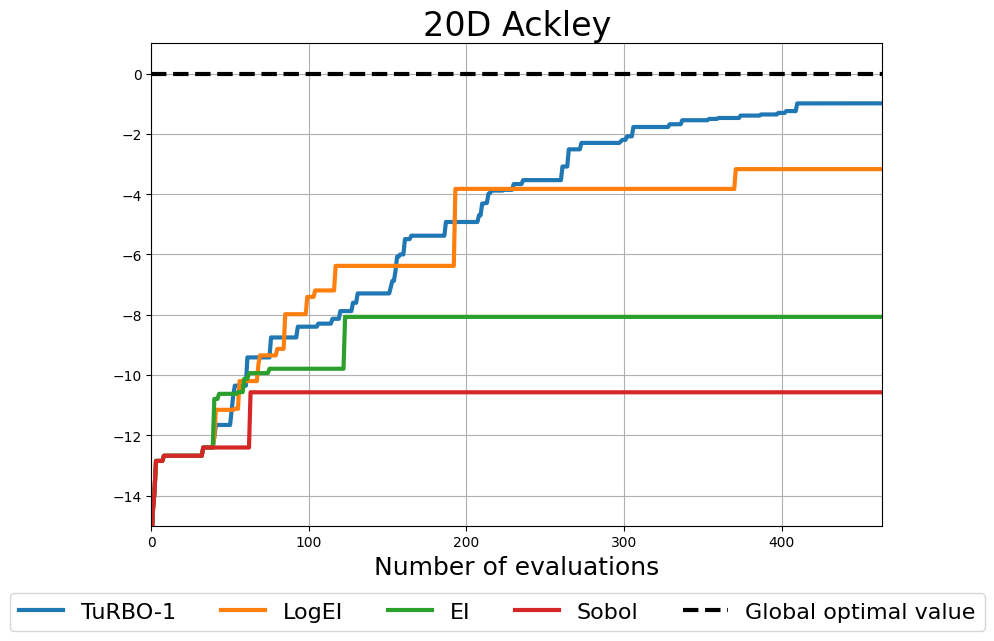

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline

names = ["TuRBO-1", "LogEI", "EI", "Sobol"]
runs = [Y_turbo, Y_logei, Y_ei, Y_Sobol]
fig, ax = plt.subplots(figsize=(8, 6))

for _name, run in zip(names, runs, strict=True):
    fx = np.maximum.accumulate(run.cpu())
    plt.plot(fx, marker="", lw=3)

plt.plot([0, len(Y_turbo)], [fun.optimal_value, fun.optimal_value], "k--", lw=3)
plt.xlabel("Function value", fontsize=18)
plt.xlabel("Number of evaluations", fontsize=18)
plt.title("20D Ackley", fontsize=24)
plt.xlim([0, len(Y_turbo)])
plt.ylim([-15, 1])

plt.grid(visible=True)
plt.tight_layout()
plt.legend(
    [*names, "Global optimal value"],
    loc="lower center",
    bbox_to_anchor=(0, -0.08, 1, 1),
    bbox_transform=plt.gcf().transFigure,
    ncol=5,
    fontsize=16,
)
plt.show()